In [1]:
# === Cell 1: 2D Heat Equation Simulation and Save to CSV ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
nx, ny = 50, 50
nt = 100
lx, ly = 1.0, 1.0
dx, dy = lx/nx, ly/ny
dt = 0.001
alpha = 0.01  # thermal diffusivity

x = np.linspace(0, lx, nx)
y = np.linspace(0, ly, ny)
t = np.arange(0, nt*dt, dt)

# Initialize temperature field
u = np.zeros((nx, ny, nt))
X, Y = np.meshgrid(x, y, indexing="ij")
u[:,:,0] = np.exp(-50*((X-0.5)**2 + (Y-0.5)**2))  # Gaussian IC

# Time stepping (explicit FTCS)
for k in range(0, nt-1):
    u_xx = (np.roll(u[:,:,k], -1, axis=0) - 2*u[:,:,k] + np.roll(u[:,:,k], 1, axis=0)) / dx**2
    u_yy = (np.roll(u[:,:,k], -1, axis=1) - 2*u[:,:,k] + np.roll(u[:,:,k], 1, axis=1)) / dy**2
    u[:,:,k+1] = u[:,:,k] + alpha * dt * (u_xx + u_yy)

# Save to CSV
X, Y, T = np.meshgrid(x, y, t, indexing="ij")
df = pd.DataFrame({
    "x": X.ravel(),
    "y": Y.ravel(),
    "t": T.ravel(),
    "u": u.ravel()
})
df.to_csv("rawdata.csv", index=False)
print("Saved rawdata.csv with shape:", df.shape)


Saved rawdata.csv with shape: (250000, 4)


In [2]:
# === Cell 2: Load Data ===
df = pd.read_csv("rawdata.csv")
print(df.head())

x = np.unique(df["x"].values)
y = np.unique(df["y"].values)
t = np.unique(df["t"].values)

u = df["u"].values.reshape(len(x), len(y), len(t))
print("u.shape =", u.shape)


     x    y      t             u
0  0.0  0.0  0.000  1.388794e-11
1  0.0  0.0  0.001  1.508033e-11
2  0.0  0.0  0.002  1.634005e-11
3  0.0  0.0  0.003  1.766995e-11
4  0.0  0.0  0.004  1.907300e-11
u.shape = (50, 50, 100)


In [3]:
import ipywidgets as widgets
from ipywidgets import interact

def plot_snapshot(k):
    plt.figure(figsize=(6,6))
    plt.contourf(x, y, u[:,:,k].T, 80, cmap="hot")
    plt.colorbar(label="Temperature u(x,y,t)")
    plt.title(f"t = {t[k]:.3f}")
    plt.xlabel("x"); plt.ylabel("y")
    plt.show()

interact(plot_snapshot, k=widgets.IntSlider(min=0, max=len(t)-1, step=1, value=0))


interactive(children=(IntSlider(value=0, description='k', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_snapshot(k)>

In [4]:
# === Cell 3: Derivatives (central differences, higher order) ===

nt, nx, ny = len(t), len(x), len(y)

# Allocate arrays
u_t   = np.zeros_like(u)
u_2t  = np.zeros_like(u)
u_x   = np.zeros_like(u)
u_2x  = np.zeros_like(u)
u_3x  = np.zeros_like(u)
u_y   = np.zeros_like(u)
u_2y  = np.zeros_like(u)
u_3y  = np.zeros_like(u)

# Loop over interior points (skip edges for higher-order stencils)
for k in range(1, nt-1):
    for i in range(2, nx-2):
        for j in range(2, ny-2):
            # Time derivatives
            u_t[i,j,k]  = (u[i,j,k+1] - u[i,j,k-1]) / (2*dt)
            u_2t[i,j,k] = (u[i,j,k+1] - 2*u[i,j,k] + u[i,j,k-1]) / (dt**2)

            # Space derivatives (x direction)
            u_x[i,j,k]  = (u[i+1,j,k] - u[i-1,j,k]) / (2*dx)
            u_2x[i,j,k] = (u[i+1,j,k] - 2*u[i,j,k] + u[i-1,j,k]) / (dx**2)
            u_3x[i,j,k] = (u[i+2,j,k] - 2*u[i+1,j,k] + 2*u[i-1,j,k] - u[i-2,j,k]) / (2*dx**3)

            # Space derivatives (y direction)
            u_y[i,j,k]  = (u[i,j+1,k] - u[i,j-1,k]) / (2*dy)
            u_2y[i,j,k] = (u[i,j+1,k] - 2*u[i,j,k] + u[i,j-1,k]) / (dy**2)
            u_3y[i,j,k] = (u[i,j+2,k] - 2*u[i,j+1,k] + 2*u[i,j-1,k] - u[i,j-2,k]) / (2*dy**3)

print("Derivatives computed: u_t, u_2t, u_x, u_2x, u_3x, u_y, u_2y, u_3y")


Derivatives computed: u_t, u_2t, u_x, u_2x, u_3x, u_y, u_2y, u_3y


In [5]:
# === Cell 4: Candidate Library with higher-order derivatives ===

U    = u.ravel()
Ut   = u_t.ravel()
U2t  = u_2t.ravel()
Ux   = u_x.ravel()
U2x  = u_2x.ravel()
U3x  = u_3x.ravel()
Uy   = u_y.ravel()
U2y  = u_2y.ravel()
U3y  = u_3y.ravel()

# Candidate terms (can add nonlinear ones if needed)
Theta = np.column_stack([
    U,
    Ux, U2x, U3x,
    Uy, U2y, U3y
])

feature_names = [
    "u",
    "u_x", "u_xx", "u_xxx",
    "u_y", "u_yy", "u_yyy"
]

print("Theta shape:", Theta.shape)


Theta shape: (250000, 7)


Discovered PDE: u_t =
  0.00086 * u
  0.01002 * u_xx
  0.01002 * u_yy


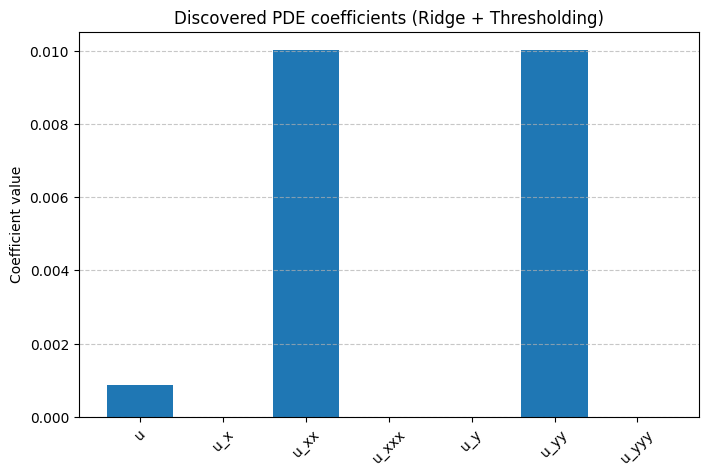

In [6]:
from sklearn.linear_model import Ridge

target = Ut  # try U2t if you want to explore wave-like PDEs

ridge = Ridge(alpha=1e-6, fit_intercept=False)
ridge.fit(Theta, target)
coeffs = ridge.coef_

threshold = 1e-6
for _ in range(10):
    small_idx = np.abs(coeffs) < threshold
    if np.all(small_idx): break
    Theta_reduced = Theta[:, ~small_idx]
    ridge.fit(Theta_reduced, target)
    coeffs_reduced = ridge.coef_
    coeffs = np.zeros_like(coeffs)
    coeffs[~small_idx] = coeffs_reduced

print("Discovered PDE: u_t =")
for name, c in zip(feature_names, coeffs):
    if abs(c) > 1e-10:
        print(f"  {c:.5f} * {name}")
plt.figure(figsize=(8,5))
plt.bar(feature_names, coeffs)
plt.xticks(rotation=45)
plt.ylabel("Coefficient value")
plt.title("Discovered PDE coefficients (Ridge + Thresholding)")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.show()


Discovered PDE with Lasso: u_t =
  0.00014 * u
  0.01001 * u_xx
  0.01001 * u_yy


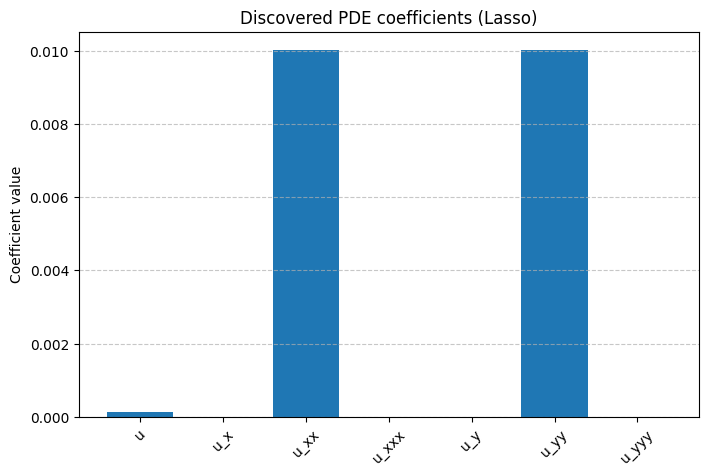

In [7]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=1e-5, fit_intercept=False, max_iter=10000)
lasso.fit(Theta, target)
coeffs_lasso = lasso.coef_

print("Discovered PDE with Lasso: u_t =")
for name, c in zip(feature_names, coeffs_lasso):
    if abs(c) > 1e-10:
        print(f"  {c:.5f} * {name}")
plt.figure(figsize=(8,5))
plt.bar(feature_names, coeffs_lasso)
plt.xticks(rotation=45)
plt.ylabel("Coefficient value")
plt.title("Discovered PDE coefficients (Lasso)")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.show()

